In [1]:
# Virtual Environment

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv('./bike_train.csv')

print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


##  Understadning, Wrangling and Cleaning Data

In [2]:
# check the data shape, colume type, number of null
bike_df.info()
bike_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [3]:
# Convert Object to datetime type 
# pandas offer date conversion method -> apply(pd.to_datetime)
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime) 

# Extract year, month, day, and time from datetime type
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

# datetime from "bike_df.datetime" means column name, not keyword in panda methods. What a coincidence!

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


The sum of the 'casual column' and the 'registered column' is the 'count column'. The 'casual column' and the 'registered column' will be deleted becuase the correlation between the three columns is high, which may hinder the prediction. 

In [4]:
drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1,inplace=True)

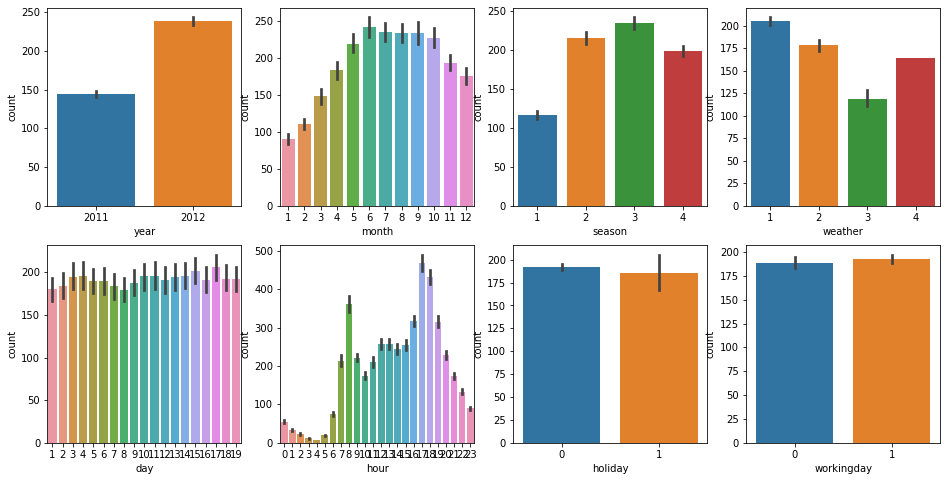

In [5]:
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
cat_features = ['year', 'month','season','weather','day', 'hour', 'holiday','workingday']
# Visualize the sum of counts according to individual column values for every column in cat_features as a barplot

for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i%4
    # Explore the sum of counts according to column values using the boxplot of Seabone
    sns.barplot(x=feature, y='count', data=bike_df, ax=axs[row][col])

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# We will use RMSLE(Root Mean Squre Log Error) as the prediction performance evaluation method.
# We will calculate RMSLE becuase scikit learn does not provide rmsle calculation

# RMSLE calculation using log1p() instead of log() due to issues such as NaN ( overflow/underflow errors) when converting log values.
# The caculated result using RMSLE calculation using log1p() can be easily restored to the original scale with NumPy's expm1() function.
 
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# Calculate RMSE using mean_square_error() of ScikitLearn
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# Calculate MSE, RMSE, RMSLE
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE is calculated with mean_absolute_error() of scikit learn
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

# Data Manipulation
Log transformation, feature encoding, model training/prediction/evaluation

We will do data manipulation first before applying the regression model. 
Data manipulation involves two processes. ## Checking whether the result is normally distributed ## In the case of a categorical regression model, one-hot encoding is used to encode features.

In [7]:
# We will use sklearn's 'LinearRegression' object to perform regression prediction.

from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


Considering the number of rentals (Count), which is the actual target data value, a relatively large value came out as a prediction error. 

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924

In order to check the difference between the actual value and the predicted value, I will create a column of DataFrame and check only 5 columns in the order of the largest error value.

In [8]:
def get_top_error_data(y_test, pred, n_tops = 5):
    
    # Create columns in the DataFrame so that the actual rental count and predicted values can be compared with each other. 
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    
    # Output the data in the order of the largest predicted and actual values. 
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
get_top_error_data(y_test,pred,n_tops=5) 

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


The error value (diff) shown in Top5 is about 500 (546-568). Compared with the actual 'real_count' value, this error value is rather large. When such a large prediction error occurs in regression, the first thing to look at is to check whether the distribution of target values is distorted. If the distribution of target values is very different from the normal distribution, there is a high possibility that the regression prediction performance will deteriorate.

Using hist() of the Pandas DataFrame, we will check how similar the target value of the bicycle rental model is to the normal distribution in the count column.

<AxesSubplot:>

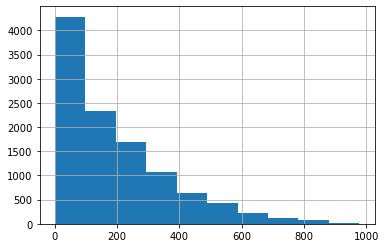

In [9]:
y_target.hist()

The count values are clustered between 0 and 200, not from a bell-shaped normal distribution.

To convert to a normal distribution, we will take a log transformation. Based on this log-transformed target, the predicted value can be restored to the original scale value by applying the expm1() function again. We will check the distribution of 'count' values to which log1p() is applied.
More about this source text

<AxesSubplot:>

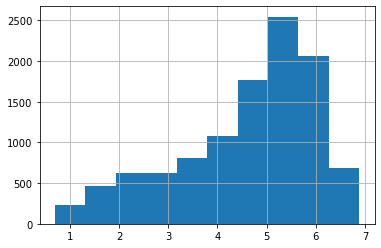

In [10]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

The target value that has undergone log transformation is less distorted than before. We will use this to learn again and then perform evaluation.

In [11]:
# Logarithmic conversion of the target column count value to log1p
y_target_log = np.log1p(y_target)

# Split the training/test data set by reflecting the log-transformed y_target_log
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# Since the target value of the test data set is log-transformed, it is converted back to the original scale using expm1.
y_test_exp = np.expm1(y_test)

# The predicted value was also learned and predicted based on the log-transformed target, so scale-transformed back to exmp1
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


The RMSLE error value decreased (1/165 -> 1.017), but the RMSE error value became larger (140.900 -> 162.594). Let's take a look at the encoding of individual features. First, we will visualize the regression coefficient values of each feature as a bar plot.

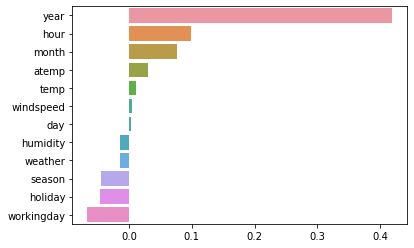

In [12]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.savefig('log_transform.tif', format='tif', dpi=300, bbox_inches='tight')

The regression coefficients of the features are highly influential. In particular, in the case of year(i.e., 2011, 2012), it is not a numeric variable, but a cagegori variable, so it must be converted by applying one-hot encoding to the feature encoding.

We'll use pandas' get_dummy() to perform one-hot encoding of the columns.

In [13]:
# One Hot Encoding of features such as year', month', 'day', hour'
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month','day', 'hour', 'holiday',
                                              'workingday','season','weather'])

We will learn the linear regression models of sklearn, LinearRegression, Ridge, and Lasso, and check the prediction performance. To do this, we will create a function get_model_predict() that returns a performance evaluation figure when we input a model and training/test dataset.

In [14]:
# Split training/prediction data based on feature dataset with one-hot encoding(ohe) applied. 
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

# Return a performance evaluation value when you input the model and training/test data set
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
# end of function get_model_predict    

# Evaluate by model
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.687, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


After applying one-hot encoding, the predictive performance of linear regression is greatly improved. 
(RMSLE: 1.165-> 1.017-> 0.590) 

We will visualize the features with high regression coefficients in the one-hot encoded data set again using barplot. We will extract the top 25 features of the regression system as the features are increased by one-hot encoding.

<AxesSubplot:>

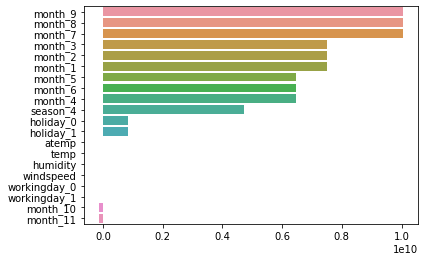

In [19]:
coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

## Random Forest, GBM, XGBoost, LightGBM
This time, we will perform regression prediction using a regression tree. We will evaluate the performance of Random Forest, GBM, XGBoost, and LightGBM models sequentially using the log-transformed value of the previously applied target value and the one-in hot-coded feature data set as it is.

In [26]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Random Forest, GBM, LightGBM model evaluation
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, lgbm_reg]:
    # In the case of XGBoost, when a DataFrame is input, an error may occur depending on the version. Convert to ndarray.
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.354, RMSE: 50.165, MAE: 31.117
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.342, MAE: 32.752
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029


The prediction performance was improved when a regression tree was used compared to the previous linear regression model. 
(RMSLE 0.590 -> 0.319)